In [2]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt

# utils
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torchsummary import summary
import time
import copy

#train
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau



from xeception import *
from train import *

from dataset import *


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

IMG_SIZE = 640
BATCH_SIZE = 32
TRAIN_RATIO = 0.2

torch.cuda.reset_max_memory_allocated(device=None)
torch.cuda.empty_cache()

/home/cgac/anaconda3/envs/contactlensEB/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


complete
cuda


/home/cgac/anaconda3/envs/contactlensEB/lib/python3.10/site-packages/torch/cuda/memory.py:271: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [3]:
# define transformation
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(IMG_SIZE)
])

In [3]:
img_dir = './data/images'
train_df, val_df, NUM_CLS, cls_list = get_data_from_csv(csv_path='./data/images/result.csv',img_dir=img_dir, train_ratio=TRAIN_RATIO, randoms_state=42)
train_df, val_df, NUM_CLS, cls_list

num of train_df 103900
num of val_df 25975
number of class:  7
['good', 'b_edge', 'burr', 'borken', 'b_bubble', 'etc', 'no_lens']


(                                   id  good  b_edge  burr  borken  b_bubble  \
 26355   None_20230406093512_2_L_1.jpg     0       0     0       0         0   
 73092   None_20230419122345_4_R_1.jpg     1       0     0       0         0   
 28640   None_20230406121442_1_R_1.jpg     1       0     0       0         0   
 123399  None_20230504154738_1_R_1.jpg     1       0     0       0         0   
 47450   None_20230413150317_3_L_1.jpg     1       0     0       0         0   
 ...                               ...   ...     ...   ...     ...       ...   
 128106  None_20230508111312_2_L_1.jpg     1       0     0       0         0   
 103694  None_20230425142245_4_R_1.jpg     1       0     0       0         0   
 860     None_20220921194238_1_L_1.jpg     0       1     0       0         0   
 15795   None_20230404122425_3_L_1.jpg     0       0     0       0         0   
 121958  None_20230504145415_1_R_1.jpg     1       0     0       0         0   
 
         etc  no_lens  
 26355     0  

In [4]:

train_set = CustomDataset(train_df,num_classes=NUM_CLS, image_dir=img_dir, class_list= cls_list ,img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE))
train_set.transforms = transformation

val_set = CustomDataset(val_df,num_classes=NUM_CLS, image_dir=img_dir, class_list= cls_list, img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE))
val_set.transforms = transformation

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=8)
val_loader = DataLoader(train_set, batch_size=int(BATCH_SIZE*TRAIN_RATIO), num_workers=4)


In [5]:
model = Xception(num_classes=NUM_CLS).to(device)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)


Let's use 2 GPUs!


In [6]:
# x = torch.randn(3, 3, IMG_SIZE, IMG_SIZE).to(device)

# output = model(x)
# print('output size:', output.size())
# summary(model, (3, IMG_SIZE, IMG_SIZE), device=device.type, verbose=0)

In [7]:
# define loss function, optimizer, lr_scheduler
loss_func = nn.MultiLabelSoftMarginLoss()
opt = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=50)

params_train = {
    'num_epochs':300,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_loader,
    'val_dl':val_loader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

traind_model, loss_hist, metric_hist = train_val(model, device, params_train)

Epoch 0/299


100%|██████████| 449/449 [01:43<00:00,  4.36batch/s]


Copied best model weights!
train loss: 0.093646, val loss: 0.093104, accuracy: 0.16, time: 3.8197 min
Epoch 1/299


100%|██████████| 449/449 [01:43<00:00,  4.35batch/s]


train loss: 0.092465, val loss: 0.095943, accuracy: 0.16, time: 7.5396 min
Epoch 2/299


100%|██████████| 449/449 [01:42<00:00,  4.36batch/s]


train loss: 0.092393, val loss: 0.098114, accuracy: 0.16, time: 11.2539 min
Epoch 3/299


100%|██████████| 449/449 [01:42<00:00,  4.36batch/s]


train loss: 0.092330, val loss: 0.096444, accuracy: 0.15, time: 14.9703 min
Epoch 4/299


100%|██████████| 449/449 [01:43<00:00,  4.36batch/s]


train loss: 0.092155, val loss: 0.093654, accuracy: 0.16, time: 18.6894 min
Epoch 5/299


100%|██████████| 449/449 [01:43<00:00,  4.36batch/s]


Copied best model weights!
train loss: 0.092150, val loss: 0.092548, accuracy: 0.16, time: 22.4389 min
Epoch 6/299


100%|██████████| 449/449 [01:43<00:00,  4.36batch/s]


Copied best model weights!
train loss: 0.092096, val loss: 0.092062, accuracy: 0.16, time: 26.1793 min
Epoch 7/299


100%|██████████| 449/449 [01:43<00:00,  4.35batch/s]


train loss: 0.092107, val loss: 0.093664, accuracy: 0.16, time: 29.9049 min
Epoch 8/299


100%|██████████| 449/449 [01:43<00:00,  4.35batch/s]


train loss: 0.092034, val loss: 0.092520, accuracy: 0.16, time: 33.6326 min
Epoch 9/299


100%|██████████| 449/449 [01:42<00:00,  4.36batch/s]


train loss: 0.091990, val loss: 0.093220, accuracy: 0.16, time: 37.3510 min
Epoch 10/299


100%|██████████| 449/449 [01:43<00:00,  4.35batch/s]


train loss: 0.091981, val loss: 0.092897, accuracy: 0.16, time: 41.0731 min
Epoch 11/299


100%|██████████| 449/449 [01:43<00:00,  4.34batch/s]


train loss: 0.091967, val loss: 0.092382, accuracy: 0.16, time: 44.8066 min
Epoch 12/299


100%|██████████| 449/449 [01:43<00:00,  4.34batch/s]


train loss: 0.091924, val loss: 0.093361, accuracy: 0.16, time: 48.5304 min
Epoch 13/299


100%|██████████| 449/449 [01:43<00:00,  4.34batch/s]


train loss: 0.091897, val loss: 0.093165, accuracy: 0.16, time: 52.2544 min
Epoch 14/299


100%|██████████| 449/449 [01:44<00:00,  4.31batch/s]


train loss: 0.091892, val loss: 0.092315, accuracy: 0.16, time: 55.9924 min
Epoch 15/299


100%|██████████| 449/449 [01:42<00:00,  4.39batch/s]


train loss: 0.091868, val loss: 0.092272, accuracy: 0.16, time: 59.6876 min
Epoch 16/299


100%|██████████| 449/449 [01:42<00:00,  4.38batch/s]


train loss: 0.091830, val loss: 0.092352, accuracy: 0.16, time: 63.3874 min
Epoch 17/299


 28%|██▊       | 24/85 [00:35<01:25,  1.39s/batch]

In [3]:

lossdf = pd.DataFrame(loss_hist)
accdf = pd.DataFrame(metric_hist)

lossdf.to_csv('loss.csv')
accdf.to_csv('acc.csv')

,train,val
0,0.103914,0.244297
1,0.093796,0.127907
2,0.093995,0.622957
3,0.093133,0.158421
4,0.092500,0.097695
5,0.092248,0.120962
6,0.092089,0.107563
7,0.092006,0.106982
8,0.091938,0.107587
9,0.091895,0.107123


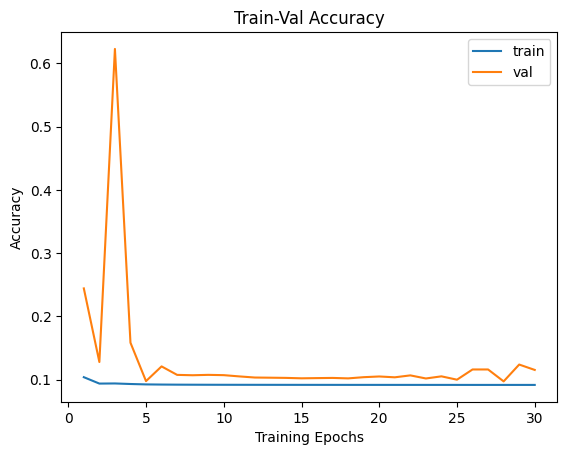

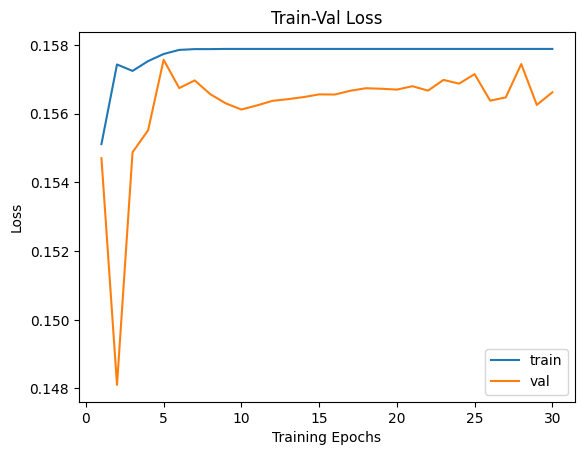

In [ ]:
import visual

visual.plot_train_val_accuracy(params_train['num_epochs'], loss_hist)
visual.plot_train_val_loss(params_train['num_epochs'], metric_hist)
